# Oak Wilt Disease Prediction Using Remote Sensing and Climate Data

This notebook implements a predictive model for Oak Wilt Disease (OWD) based on remote sensing data (NDVI from Sentinel-2) and climate variables, following the research approach outlined in the paper.

In [22]:
# !pip install scikit-learn 
#!pip install xgboost
!pip uninstall xgboost -y
!pip install xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [30]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
#import shap
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
np.random.seed(42)

## 1. Load the Oak Wilt Data

First, we load our cleaned shapefile with oak wilt occurrences.

In [31]:
# Load the cleaned oak wilt data from shapefile
def load_oak_wilt_data(shapefile_path='oak_wilt_minnesota.shp'):
    """Load the cleaned oak wilt data from shapefile"""
    gdf = gpd.read_file(shapefile_path)
    print(f"Loaded {len(gdf)} oak wilt records from shapefile")
    return gdf

gdf = load_oak_wilt_data()
gdf.head()

Loaded 9880 oak wilt records from shapefile


,Unnamed_ 0,KEY,objectid,reporter,RecOwner,SciName,ComName,Nativity,OccStatus,Status,...,Comments,ReviewDate,Reviewer,VerifyMthd,Verified,IDCred,ReviewComm,lat,lng,geometry
0,206,Anoka_Minnesota,8516579,Minnesota Department of Natural Resources Fore...,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,"""confirmed sometime in 1997; 8/15/1997 is an a...",7/7/2020,Brian Schwingle,Bulk Verified,Verified,Credible,None,45.2733,-93.2465,POINT (-93.30105 45.16767)
1,207,Anoka_Minnesota,8520869,Minnesota Department of Natural Resources Fore...,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,"""confirmed sometime in 2001; 8/15/2001 is an a...",7/7/2020,Brian Schwingle,Bulk Verified,Verified,Credible,None,45.2733,-93.2465,POINT (-93.0413 45.27451)
2,208,Anoka_Minnesota,8520870,Minnesota Department of Natural Resources Fore...,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,"""confirmed sometime in 2001; 8/15/2001 is an a...",7/7/2020,Brian Schwingle,Bulk Verified,Verified,Credible,None,45.2733,-93.2465,POINT (-93.02445 45.30835)
3,209,Anoka_Minnesota,8516016,Minnesota Department of Natural Resources Fore...,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,"""confirmed sometime in 1991; 8/15/1991 is an a...",7/7/2020,Brian Schwingle,Bulk Verified,Verified,Credible,None,45.2733,-93.2465,POINT (-93.22283 45.18486)
4,210,Anoka_Minnesota,8520582,Minnesota Department of Natural Resources Fore...,State Agency,Bretziella fagacearum,oak wilt,Introduced,Detected,Positive,...,"""confirmed sometime in 2001; 8/15/2001 is an a...",7/7/2020,Brian Schwingle,Bulk Verified,Verified,Credible,None,45.2733,-93.2465,POINT (-93.33244 45.3662)


## 2. Visualize the Oak Wilt Distribution

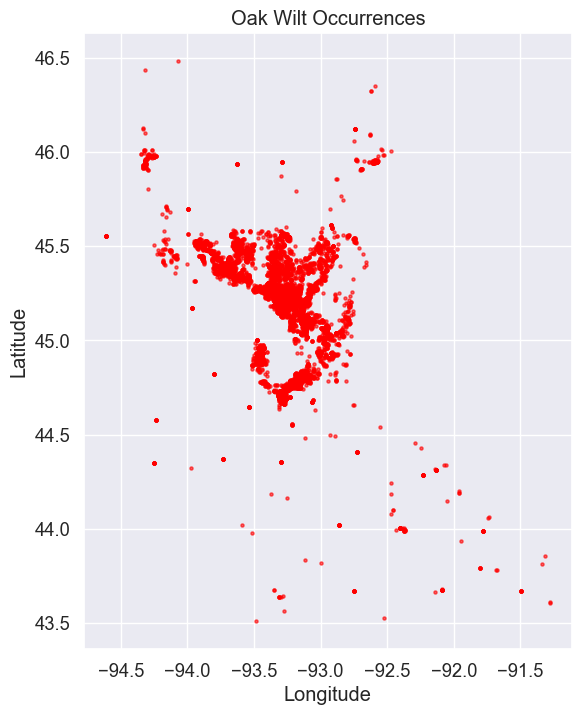

In [32]:
# Plot the distribution of oak wilt occurrences
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.6)
ax.set_title('Oak Wilt Occurrences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## 3. Generate Climate Data

Generating simulated climate data from 2023-01-01 to 2023-12-31
ERROR! Session/line number was not unique in database. History logging moved to new session 25
Generated climate data with 365 daily records


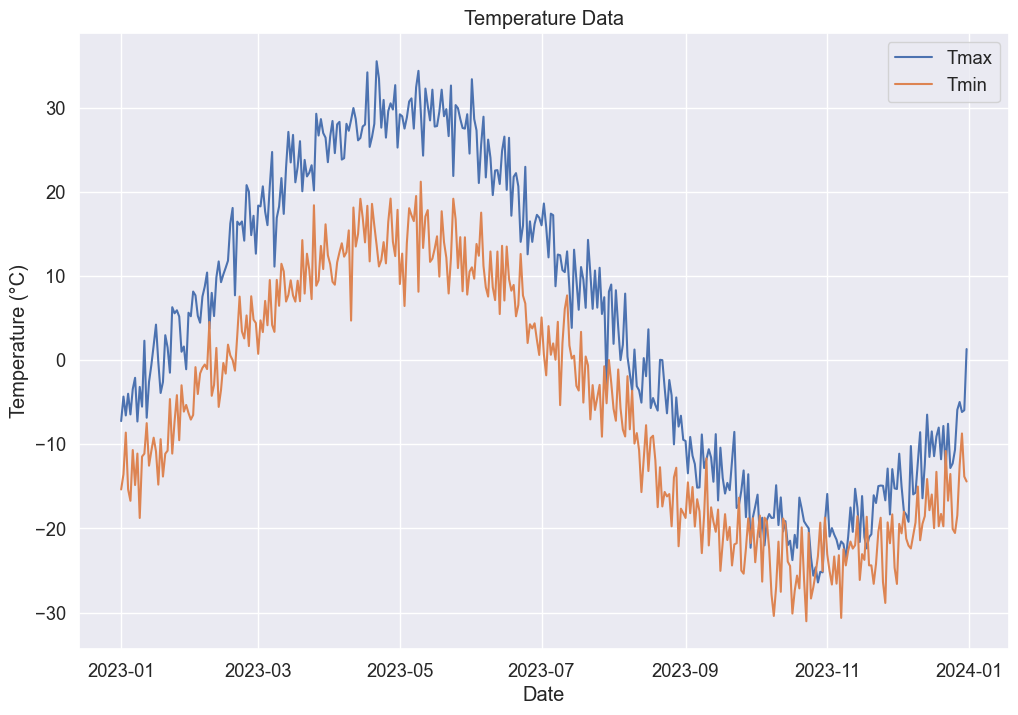

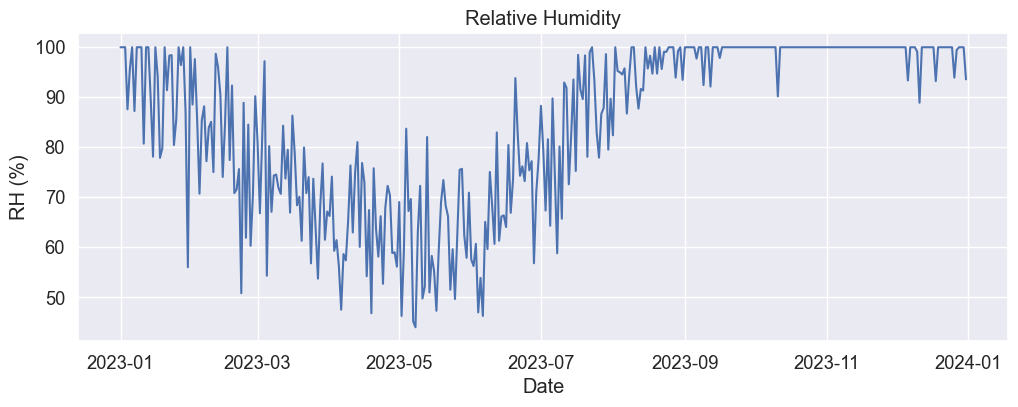

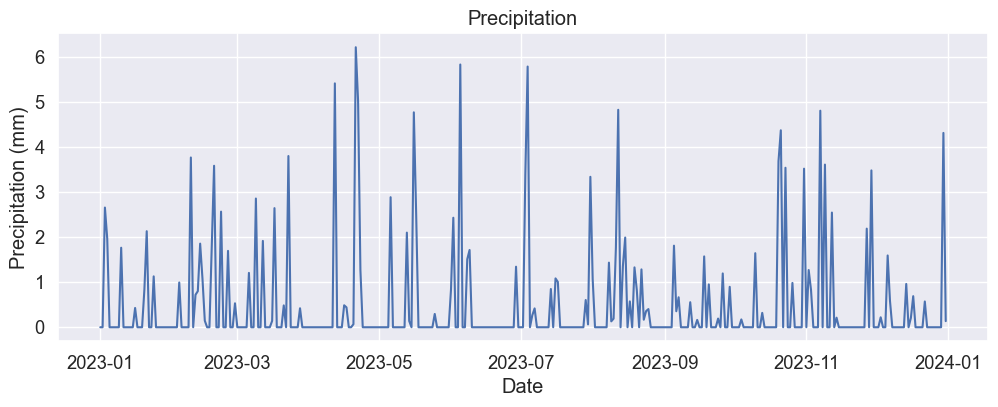

In [35]:
def get_climate_data(date_start, date_end):
    """Generate simulated climate data"""
    print(f"Generating simulated climate data from {date_start} to {date_end}")
    
    # Create date range
    dates = pd.date_range(start=date_start, end=date_end, freq='D')
    
    # Create a DataFrame to store climate data
    climate_df = pd.DataFrame(index=dates)
    
    # Simulate climate data
    for date in dates:
        # Day of year (0-365)
        doy = date.dayofyear
        
        # Temperature varies with season
        tmax_base = 5 + 25 * np.sin((doy - 30) * np.pi / 180)  # Peak in summer
        tmin_base = -5 + 20 * np.sin((doy - 30) * np.pi / 180)  # Peak in summer
        
        # Add some random variation
        tmax = tmax_base + np.random.normal(0, 3)
        tmin = tmin_base + np.random.normal(0, 3)
        
        # Relative humidity varies inversely with temperature
        rh_base = 90 - 30 * np.sin((doy - 30) * np.pi / 180)  # Lower in summer
        rh = rh_base + np.random.normal(0, 10)
        rh = max(10, min(100, rh))  # Constrain to 10-100%
        
        # Precipitation occurs randomly
        pr = np.random.exponential(1.5) if np.random.random() < 0.3 else 0
        
        # Wind speed and direction
        ws = np.random.gamma(2, 2)
        wd = np.random.uniform(0, 360)
        
        # Store in DataFrame
        climate_df.loc[date, 'Tmax'] = tmax
        climate_df.loc[date, 'Tmin'] = tmin
        climate_df.loc[date, 'RH'] = rh
        climate_df.loc[date, 'PR'] = pr
        climate_df.loc[date, 'WS'] = ws
        climate_df.loc[date, 'WD'] = wd
    
    print(f"Generated climate data with {len(climate_df)} daily records")
    return climate_df

# Define study period and generate climate data
date_start = '2023-01-01'
date_end = '2023-12-31'
climate_df = get_climate_data(date_start, date_end)

# Visualize climate data
plt.figure(figsize=(12, 8))
plt.plot(climate_df.index, climate_df['Tmax'], label='Tmax')
plt.plot(climate_df.index, climate_df['Tmin'], label='Tmin')
plt.title('Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(climate_df.index, climate_df['RH'])
plt.title('Relative Humidity')
plt.xlabel('Date')
plt.ylabel('RH (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(climate_df.index, climate_df['PR'])
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

## 4. Extract NDVI Time Series

Extracting NDVI time series for 9880 points


Created simulated NDVI time series with 55 dates for each point


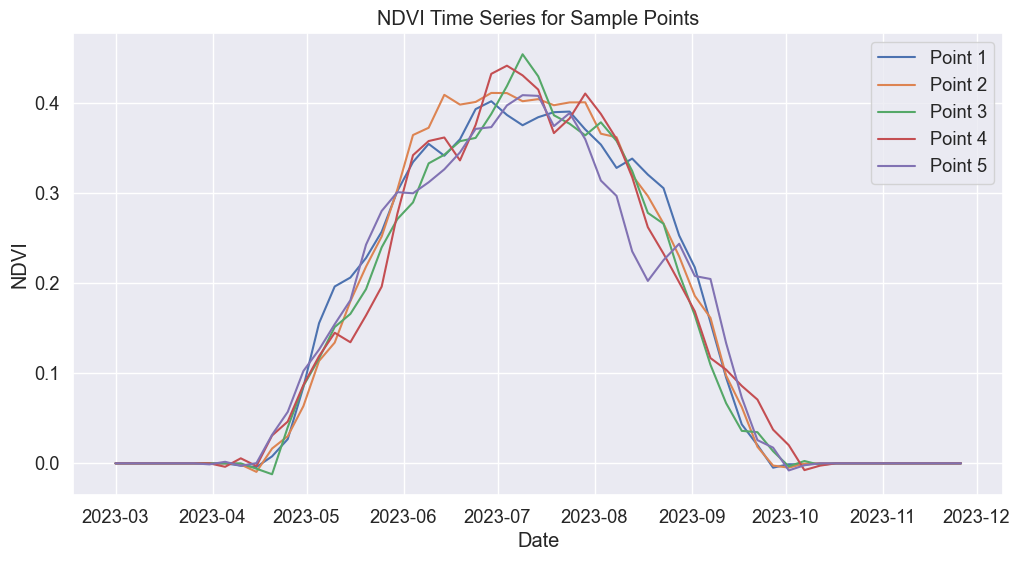

In [36]:
def extract_ndvi_timeseries(gdf, ndvi_folder):
    """Extract NDVI time series for each point in the geodataframe (simulated)"""
    print(f"Extracting NDVI time series for {len(gdf)} points")
    
    # Simulate NDVI time series data
    dates = pd.date_range(start='2023-03-01', end='2023-11-30', freq='5D')
    
    # Create an empty DataFrame to store results
    ndvi_df = pd.DataFrame(index=gdf.index)
    
    # Simulate different NDVI patterns for each point
    for idx in gdf.index:
        base_ndvi = np.zeros(len(dates))
        
        # Simulate seasonal pattern (bell-shaped curve)
        for i, date in enumerate(dates):
            # Day of year (0-365)
            doy = date.dayofyear
            
            # Seasonal pattern (peak in summer)
            seasonal = -0.1 + 0.5 * np.sin((doy - 100) * np.pi / 180)
            
            # Add some noise
            noise = np.random.normal(0, 0.05)
            
            base_ndvi[i] = max(0, min(1, seasonal + noise))
        
        # Apply smoothing to simulate realistic NDVI pattern
        smoothed_ndvi = savgol_filter(base_ndvi, window_length=7, polyorder=3)
        
        # Add to dataframe
        for i, date in enumerate(dates):
            ndvi_df.loc[idx, date.strftime('%Y-%m-%d')] = smoothed_ndvi[i]
    
    print(f"Created simulated NDVI time series with {len(dates)} dates for each point")
    return ndvi_df, dates

# Extract NDVI time series
ndvi_df, dates = extract_ndvi_timeseries(gdf, ndvi_folder='ndvi_data')

# Plot NDVI time series for a few points
plt.figure(figsize=(12, 6))
for i in range(min(5, len(ndvi_df))):
    plt.plot(dates, ndvi_df.iloc[i].values, label=f'Point {i+1}')
plt.title('NDVI Time Series for Sample Points')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.show()

## 5. Estimate Start of Season (SOS)

Estimating Start of Season (SOS) from NDVI time series
SOS estimation complete. Mean SOS day of year: 98.9


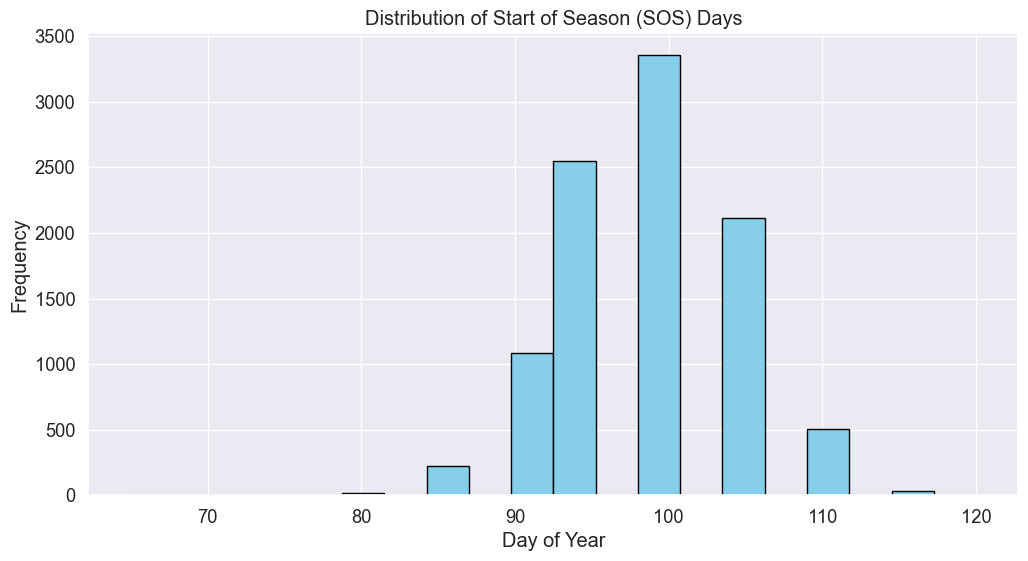

In [37]:
def estimate_sos(ndvi_df, dates):
    """Estimate the Start of Season (SOS) from NDVI time series"""
    print("Estimating Start of Season (SOS) from NDVI time series")
    
    # Create a DataFrame to store SOS dates
    sos_df = pd.DataFrame(index=ndvi_df.index, columns=['SOS_Date', 'SOS_DOY'])
    
    # For each point, estimate SOS
    for idx in ndvi_df.index:
        # Get NDVI time series for this point
        ndvi_series = ndvi_df.loc[idx]
        
        # Convert to numpy array
        ndvi_values = ndvi_series.values
        
        # Calculate derivative (difference between consecutive values)
        ndvi_derivative = np.diff(ndvi_values)
        
        # Find where derivative changes from negative to positive (local minimum)
        # This indicates the start of the growing season
        min_idx = None
        for i in range(1, len(ndvi_derivative)):
            if ndvi_derivative[i-1] <= 0 and ndvi_derivative[i] > 0:
                # Found a local minimum
                min_idx = i
                break
        
        # If no local minimum was found, use conventional approach (5% of amplitude)
        if min_idx is None:
            # Calculate min and max NDVI
            min_ndvi = np.min(ndvi_values)
            max_ndvi = np.max(ndvi_values)
            amplitude = max_ndvi - min_ndvi
            
            # Find where NDVI exceeds min + 5% of amplitude
            threshold = min_ndvi + 0.05 * amplitude
            for i in range(len(ndvi_values)):
                if ndvi_values[i] >= threshold:
                    min_idx = i
                    break
        
        # If we found a SOS date, store it
        if min_idx is not None and min_idx < len(dates):
            sos_date = dates[min_idx]
            sos_df.loc[idx, 'SOS_Date'] = sos_date
            sos_df.loc[idx, 'SOS_DOY'] = sos_date.dayofyear
        else:
            # Default to a mid-spring date if we couldn't estimate SOS
            default_date = pd.Timestamp('2023-04-15')
            sos_df.loc[idx, 'SOS_Date'] = default_date
            sos_df.loc[idx, 'SOS_DOY'] = default_date.dayofyear
    
    print(f"SOS estimation complete. Mean SOS day of year: {sos_df['SOS_DOY'].mean():.1f}")
    return sos_df

# Estimate SOS
sos_df = estimate_sos(ndvi_df, dates)

# Plot histogram of SOS dates
plt.figure(figsize=(12, 6))
plt.hist(sos_df['SOS_DOY'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Start of Season (SOS) Days')
plt.xlabel('Day of Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 6. Extract Climate Features

In [38]:
def extract_climate_features(gdf, sos_df, climate_df):
    """Extract climate features for each oak wilt observation based on SOS date"""
    print("Extracting climate features based on SOS dates")
    
    # Create a DataFrame to store features
    features_df = pd.DataFrame(index=gdf.index)
    
    # Add basic information
    features_df['Latitude'] = gdf.geometry.y
    features_df['Longitude'] = gdf.geometry.x
    features_df['SOS_Date'] = sos_df['SOS_Date']
    features_df['SOS_DOY'] = sos_df['SOS_DOY']
    
    # Define time windows (days relative to SOS)
    time_windows = {
        'BP50_41': (-50, -41),  # 50-41 days before SOS
        'BP40_31': (-40, -31),  # 40-31 days before SOS
        'BP30_21': (-30, -21),  # 30-21 days before SOS
        'BP20_11': (-20, -11),  # 20-11 days before SOS
        'BP10_01': (-10, -1),   # 10-1 days before SOS
        'AP01_10': (1, 10),     # 1-10 days after SOS
        'AP11_20': (11, 20),    # 11-20 days after SOS
        'AP21_30': (21, 30),    # 21-30 days after SOS
        'AP31_40': (31, 40),    # 31-40 days after SOS
        'AP41_50': (41, 50)     # 41-50 days after SOS
    }
    
    # Climate variables to aggregate
    climate_vars = ['Tmax', 'Tmin', 'RH', 'PR', 'WS', 'WD']
    
    # For each point
    for idx in gdf.index:
        # Get SOS date for this point
        sos_date = sos_df.loc[idx, 'SOS_Date']
        
        # For each time window
        for window_name, (start_offset, end_offset) in time_windows.items():
            # Calculate start and end dates for this window
            start_date = sos_date + pd.Timedelta(days=start_offset)
            end_date = sos_date + pd.Timedelta(days=end_offset)
            
            # Get climate data for this window
            window_climate = climate_df.loc[start_date:end_date]
            
            # Calculate aggregated features for each climate variable
            for var in climate_vars:
                # Mean value in the window
                features_df.loc[idx, f'{var}_mean_{window_name}'] = window_climate[var].mean()
                
                # Max value in the window
                features_df.loc[idx, f'{var}_max_{window_name}'] = window_climate[var].max()
                
                # Min value in the window
                features_df.loc[idx, f'{var}_min_{window_name}'] = window_climate[var].min()
                
                # Standard deviation in the window
                features_df.loc[idx, f'{var}_std_{window_name}'] = window_climate[var].std()
                
                # For precipitation, also calculate total
                if var == 'PR':
                    features_df.loc[idx, f'PR_sum_{window_name}'] = window_climate[var].sum()
    
    # Create additional features based on the research findings
    
    # 1. Number of consecutive days with Tmax > 25°C in the first 10 days after SOS
    for idx in gdf.index:
        sos_date = sos_df.loc[idx, 'SOS_Date']
        max_consecutive_days = 0
        current_consecutive_days = 0
        
        for i in range(10):
            date = sos_date + pd.Timedelta(days=i+1)
            if date in climate_df.index and climate_df.loc[date, 'Tmax'] > 25:
                current_consecutive_days += 1
                max_consecutive_days = max(max_consecutive_days, current_consecutive_days)
            else:
                current_consecutive_days = 0
        
        features_df.loc[idx, 'consecutive_hot_days_AP01_10'] = max_consecutive_days
    
    # 2. Number of days with RH < 65% in the first 10 days after SOS
    for idx in gdf.index:
        sos_date = sos_df.loc[idx, 'SOS_Date']
        low_rh_days = 0
        
        for i in range(10):
            date = sos_date + pd.Timedelta(days=i+1)
            if date in climate_df.index and climate_df.loc[date, 'RH'] < 65:
                low_rh_days += 1
        
        features_df.loc[idx, 'low_rh_days_AP01_10'] = low_rh_days
    
    # 3. Count hot and dry days (Tmax > 25°C and RH < 65%)
    for idx in gdf.index:
        sos_date = sos_df.loc[idx, 'SOS_Date']
        hot_dry_days = 0
        
        for i in range(10):
            date = sos_date + pd.Timedelta(days=i+1)
            if date in climate_df.index and climate_df.loc[date, 'Tmax'] > 25 and climate_df.loc[date, 'RH'] < 65:
                hot_dry_days += 1
        
        features_df.loc[idx, 'hot_dry_days_AP01_10'] = hot_dry_days
    
    print(f"Extracted {features_df.shape[1]} climate features for each point")
    return features_df

# Extract climate features
features_df = extract_climate_features(gdf, sos_df, climate_df)

# Display a few columns
features_df.iloc[:, :10].head()

Extracting climate features based on SOS dates
Extracted 257 climate features for each point


,Latitude,Longitude,SOS_Date,SOS_DOY,Tmax_mean_BP50_41,Tmax_max_BP50_41,Tmax_min_BP50_41,Tmax_std_BP50_41,Tmin_mean_BP50_41,Tmin_max_BP50_41
0,45.16767,-93.30105,2023-04-15 00:00:00,105,17.657596,20.814416,12.662450,2.605772,4.389054,7.602493
1,45.27451,-93.04130,2023-04-15 00:00:00,105,17.657596,20.814416,12.662450,2.605772,4.389054,7.602493
2,45.30835,-93.02445,2023-04-20 00:00:00,110,18.283974,24.751297,11.127977,3.525988,5.315365,9.549459
3,45.18486,-93.22283,2023-04-05 00:00:00,95,13.834549,18.098931,7.714540,3.434013,1.582044,7.562213
4,45.36620,-93.33244,2023-03-31 00:00:00,90,11.147173,18.098931,5.246180,3.742978,-1.427055,1.848180


## 7. Create Target Variable (OWD Onset)

Creating target variable for OWD onset prediction


Created target variable with 8659.0 onset cases (87.6% of total)


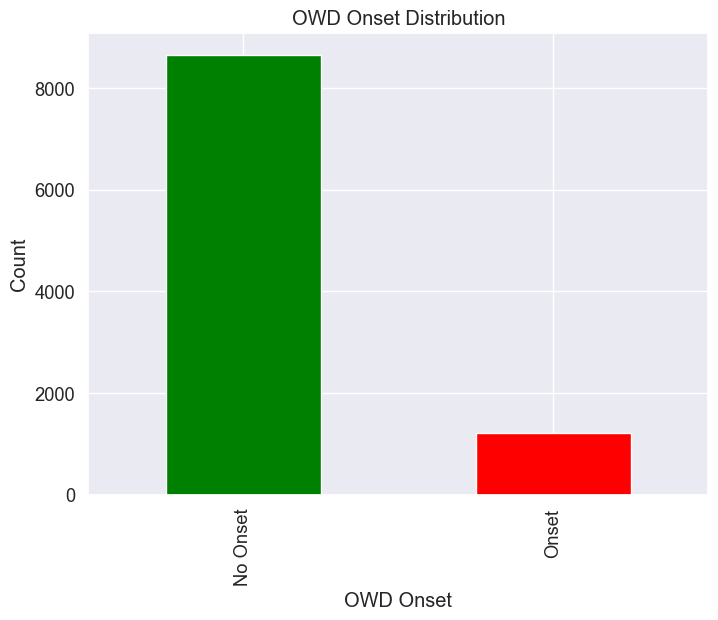

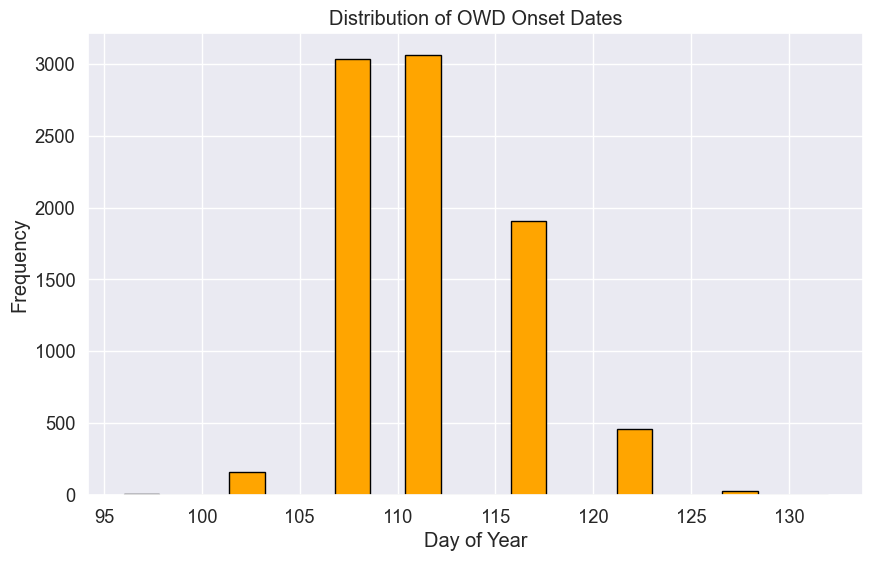

In [39]:
def create_target_variable(gdf, features_df):
    """Create a target variable for OWD onset prediction"""
    print("Creating target variable for OWD onset prediction")
    
    # Create a target DataFrame
    target_df = pd.DataFrame(index=gdf.index)
    
    # Probability of OWD onset increases with hot_dry_days
    for idx in gdf.index:
        hot_dry_days = features_df.loc[idx, 'hot_dry_days_AP01_10']
        consecutive_hot_days = features_df.loc[idx, 'consecutive_hot_days_AP01_10']
        low_rh_days = features_df.loc[idx, 'low_rh_days_AP01_10']
        
        # Base probability on climate conditions
        if hot_dry_days == 1:
            base_prob = 0.7
        else:
            # Calculate based on component factors
            base_prob = 0.1 + 0.1 * consecutive_hot_days + 0.05 * low_rh_days
        
        # Add some randomness
        prob = min(0.9, max(0.1, base_prob + np.random.normal(0, 0.1)))
        
        # Determine if OWD onset occurred
        onset = 1 if np.random.random() < prob else 0
        
        # If onset occurred, determine the onset date
        if onset == 1:
            # Onset typically occurs 10-30 days after SOS, with more likely onset
            # during periods of high temperature and low humidity
            sos_date = features_df.loc[idx, 'SOS_Date']
            
            # Base delay on climate conditions (hotter/drier = faster onset)
            delay_factor = 1 - (consecutive_hot_days / 10) - (low_rh_days / 20)
            delay_factor = max(0.1, min(1.0, delay_factor))
            
            # Calculate delay in days (10-30 days)
            delay = int(10 + 20 * delay_factor)
            
            # Calculate onset date
            onset_date = sos_date + pd.Timedelta(days=delay)
            onset_doy = onset_date.dayofyear
        else:
            onset_date = pd.NaT
            onset_doy = np.nan
        
        # Store in DataFrame
        target_df.loc[idx, 'OWD_Onset'] = onset
        target_df.loc[idx, 'OWD_Onset_Date'] = onset_date
        target_df.loc[idx, 'OWD_Onset_DOY'] = onset_doy
    
    # Count number of onset cases
    num_onset = target_df['OWD_Onset'].sum()
    print(f"Created target variable with {num_onset} onset cases ({num_onset/len(target_df)*100:.1f}% of total)")
    
    return target_df

# Create target variable
target_df = create_target_variable(gdf, features_df)

# Display distribution of onset vs. no onset
onset_counts = target_df['OWD_Onset'].value_counts()
plt.figure(figsize=(8, 6))
onset_counts.plot(kind='bar', color=['green', 'red'])
plt.title('OWD Onset Distribution')
plt.xlabel('OWD Onset')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Onset', 'Onset'])
plt.grid(True, axis='y')
plt.show()

# Plot histogram of onset dates (day of year)
plt.figure(figsize=(10, 6))
plt.hist(target_df['OWD_Onset_DOY'].dropna(), bins=20, color='orange', edgecolor='black')
plt.title('Distribution of OWD Onset Dates')
plt.xlabel('Day of Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 8. Feature Selection

Performing feature selection
  Training RandomForest for feature importance...
  Training XGBoost for feature importance...
  Training LogisticRegression for feature importance...
Selected top 20 features based on ensemble importance


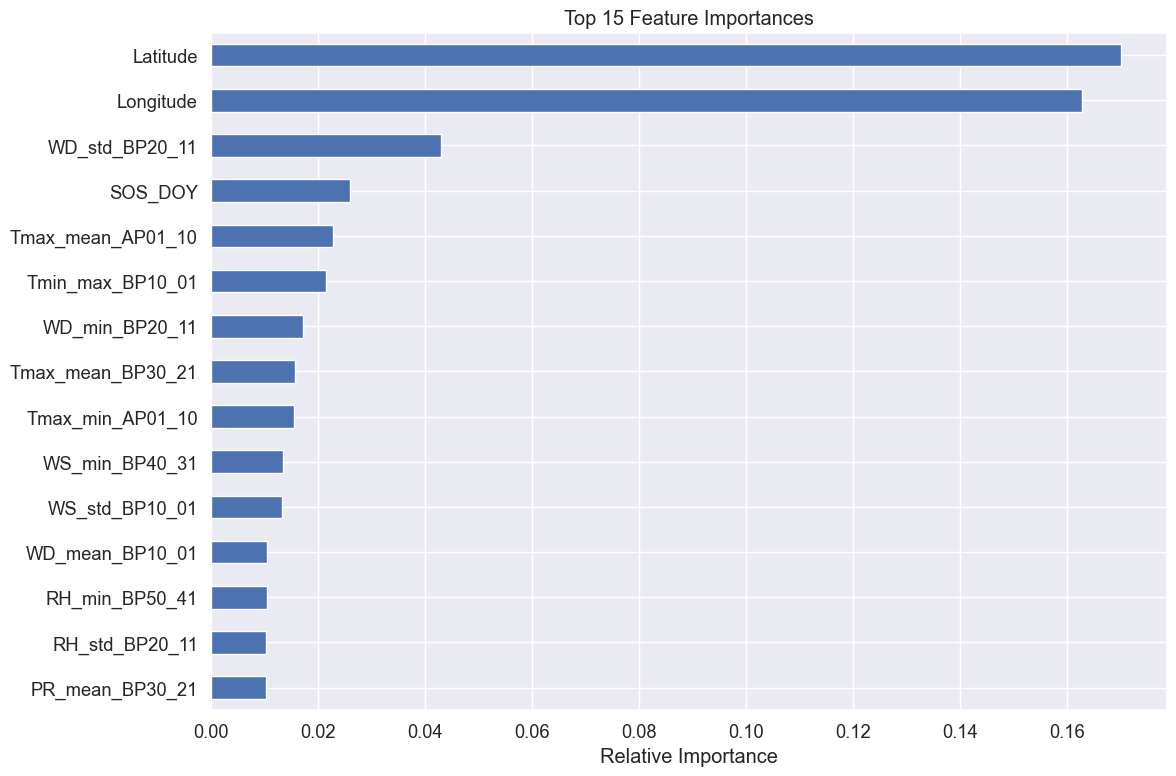

In [40]:
def feature_selection(features_df, target_df, n_features=50):
    """Perform feature selection to identify the most important predictors"""
    print("Performing feature selection")
    
    # Combine features and target for ease of processing
    X = features_df.copy()
    y = target_df['OWD_Onset'].copy()
    
    # Remove non-feature columns
    X = X.drop(columns=['SOS_Date'], errors='ignore')
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    # Feature importance methods
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42)
    }
    
    # Store feature importances from each model
    feature_importances = pd.DataFrame(index=X.columns)
    
    # Train each model and get feature importances
    for name, model in models.items():
        print(f"  Training {name} for feature importance...")
        
        # Fit the model
        model.fit(X_scaled, y)
        
        # Get feature importances
        if name in ['RandomForest', 'XGBoost']:
            # Tree-based models have feature_importances_ attribute
            importances = model.feature_importances_
        elif name in ['LogisticRegression']:
            # Linear models have coefficients
            importances = np.abs(model.coef_[0])
        else:
            importances = np.zeros(X.shape[1])
        
        # Add to DataFrame
        feature_importances[name] = importances
    
    # Calculate ensemble importance (mean across all models)
    feature_importances['Ensemble'] = feature_importances.mean(axis=1)
    
    # Sort by ensemble importance
    feature_importances = feature_importances.sort_values('Ensemble', ascending=False)
    
    # Select top features
    top_features = feature_importances.index[:n_features].tolist()
    
    print(f"Selected top {len(top_features)} features based on ensemble importance")
    
    # Return the top features and their importances
    return top_features, feature_importances

# Perform feature selection
top_features, feature_importances = feature_selection(features_df, target_df, n_features=20)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances['Ensemble'].head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## 9. CART Analysis

Performing CART analysis to identify key thresholds
Top 5 features from CART analysis:
  1. Tmax_mean_BP30_21
  2. Longitude
  3. Latitude
  4. PR_mean_BP30_21
  5. WD_mean_BP10_01


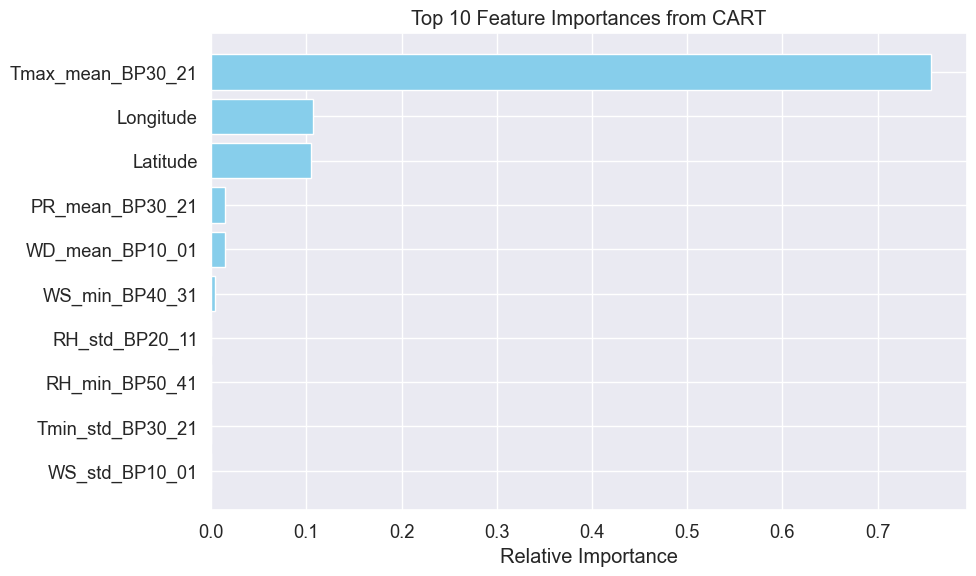

In [41]:
def cart_analysis(features_df, target_df, top_features):
    """Perform CART analysis to identify key thresholds"""
    print("Performing CART analysis to identify key thresholds")
    
    # Prepare data
    X = features_df[top_features].copy()
    y = target_df['OWD_Onset'].copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Train a decision tree with limited depth for interpretability
    cart = DecisionTreeClassifier(max_depth=5, random_state=42)
    cart.fit(X, y)
    
    # Get feature importances
    importances = cart.feature_importances_
    importance_df = pd.DataFrame({'Feature': top_features, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Get top 5 most important features from CART
    top_cart_features = importance_df.head(5)['Feature'].tolist()
    
    print("Top 5 features from CART analysis:")
    for i, feature in enumerate(top_cart_features):
        print(f"  {i+1}. {feature}")
    
    # Return the CART model and top features
    return cart, top_cart_features

# Perform CART analysis
cart_model, top_cart_features = cart_analysis(features_df, target_df, top_features)

# Plot feature importances from CART
plt.figure(figsize=(10, 6))
importances = cart_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Get indices of top 10 features
plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [top_features[i] for i in indices])
plt.title('Top 10 Feature Importances from CART')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## 10. Build and Evaluate Predictive Models

Building and evaluating predictive models for OWD onset
  Training RandomForest classification model...
    Accuracy: 0.857
    F1 Score: 0.824
  Training XGBoost classification model...
    Accuracy: 0.873
    F1 Score: 0.821
  Training SVM classification model...
    Accuracy: 0.877
    F1 Score: 0.819
  Training LogisticRegression classification model...
    Accuracy: 0.877
    F1 Score: 0.819
  Training NeuralNetwork classification model...
    Accuracy: 0.876
    F1 Score: 0.820
  Training RandomForest regression model for onset day prediction...
    RMSE: 0.000 days
    Success Ratio (±8 days): 1.000
  Training XGBoost regression model for onset day prediction...
    RMSE: 0.000 days
    Success Ratio (±8 days): 1.000


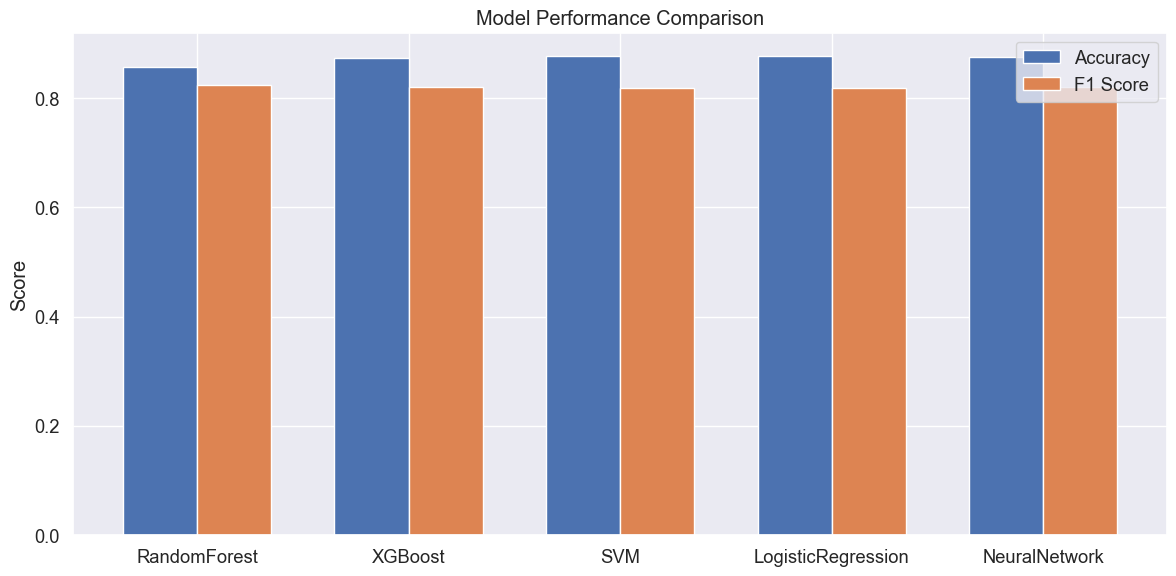

In [42]:
def build_predictive_models(features_df, target_df, top_features):
    """Build and evaluate predictive models for OWD onset"""
    print("Building and evaluating predictive models for OWD onset")
    
    # Prepare data
    X = features_df[top_features].copy()
    y_class = target_df['OWD_Onset'].copy()  # For classification
    y_reg = target_df['OWD_Onset_DOY'].copy()  # For regression (predicting onset day)
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Split data into training and testing sets
    X_train, X_test, y_class_train, y_class_test = train_test_split(
        X, y_class, test_size=0.3, random_state=42, stratify=y_class
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models for classification
    models_class = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42),
        'NeuralNetwork': MLPClassifier(hidden_layer_sizes=(100,), random_state=42)
    }
    
    # Train and evaluate classification models
    class_results = {}
    for name, model in models_class.items():
        print(f"  Training {name} classification model...")
        
        # Train the model
        model.fit(X_train_scaled, y_class_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_class_test, y_pred)
        report = classification_report(y_class_test, y_pred, output_dict=True)
        
        # Store results
        class_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        print(f"    Accuracy: {accuracy:.3f}")
        print(f"    F1 Score: {report['weighted avg']['f1-score']:.3f}")
    
    # Select records with onset for regression
    onset_idx = y_reg.notna()
    if onset_idx.sum() > 0:
        X_reg = X[onset_idx]
        y_reg = y_reg[onset_idx]
        X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
            X_reg, y_reg, test_size=0.3, random_state=42
        )
        
        # Standardize features
        X_reg_train_scaled = scaler.transform(X_reg_train)
        X_reg_test_scaled = scaler.transform(X_reg_test)
        
        # Define models for regression
        models_reg = {
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        }
        
        # Train and evaluate regression models
        reg_results = {}
        for name, model in models_reg.items():
            print(f"  Training {name} regression model for onset day prediction...")
            
            # Train the model
            model.fit(X_reg_train_scaled, y_reg_train)
            
            # Make predictions
            y_pred = model.predict(X_reg_test_scaled)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
            
            # Calculate success ratio within different windows
            windows = [3, 5, 8, 10, 15]
            success_ratios = {}
            for window in windows:
                success = np.sum(np.abs(y_pred - y_reg_test) <= window)
                success_ratio = success / len(y_reg_test)
                success_ratios[window] = success_ratio
            
            # Store results
            reg_results[name] = {
                'model': model,
                'rmse': rmse,
                'success_ratios': success_ratios,
                'y_pred': y_pred
            }
            
            print(f"    RMSE: {rmse:.3f} days")
            print(f"    Success Ratio (±8 days): {success_ratios[8]:.3f}")
    else:
        print("  No onset cases for regression modeling")
        reg_results = {}
    
    # Return results
    return class_results, reg_results

# Build and evaluate models
class_results, reg_results = build_predictive_models(features_df, target_df, top_features)

# Plot model performance comparison
model_names = list(class_results.keys())
accuracies = [class_results[name]['accuracy'] for name in model_names]
f1_scores = [class_results[name]['report']['weighted avg']['f1-score'] for name in model_names]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1 Score')
plt.xticks(x, model_names)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#

## 11. Create Prediction Maps

Creating prediction maps
Prediction accuracy: 0.878


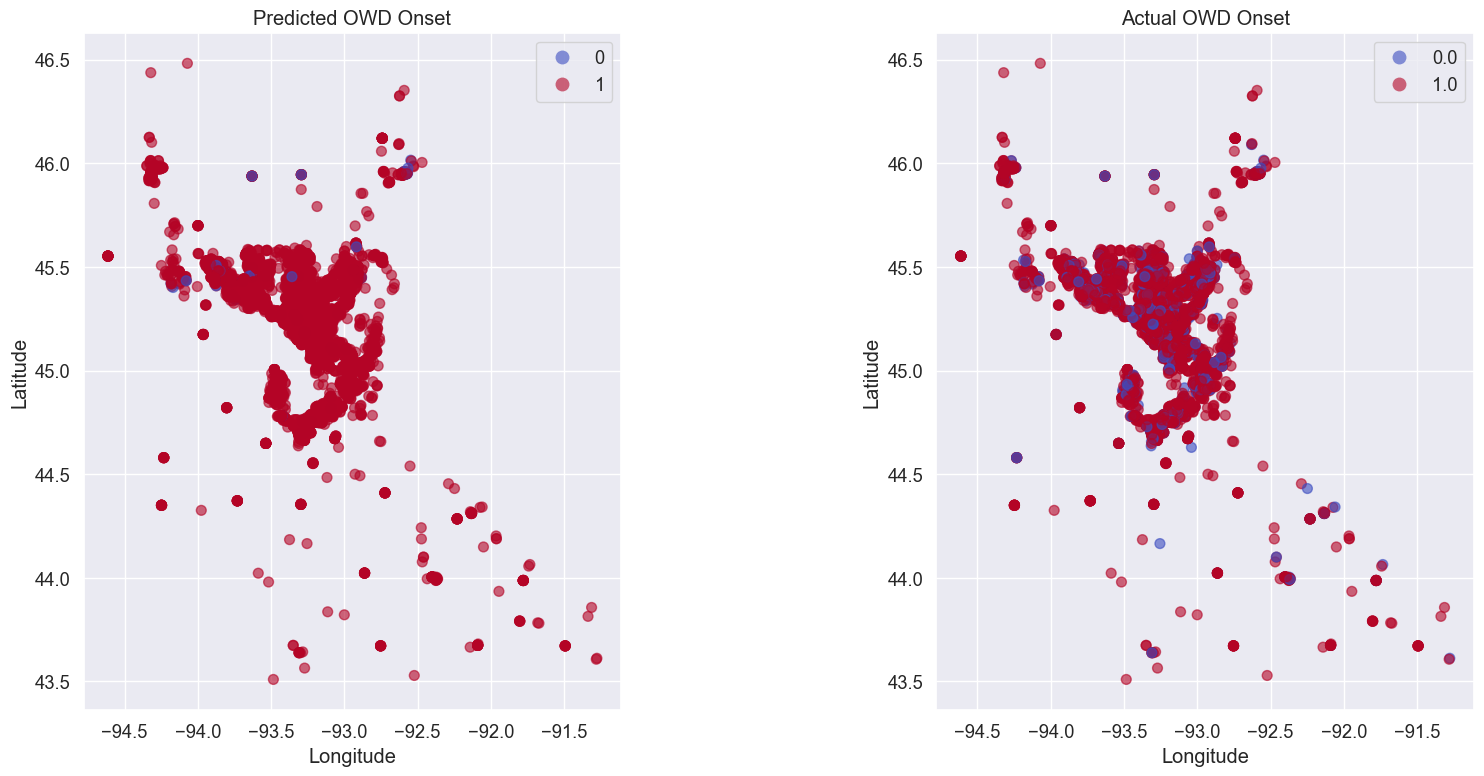

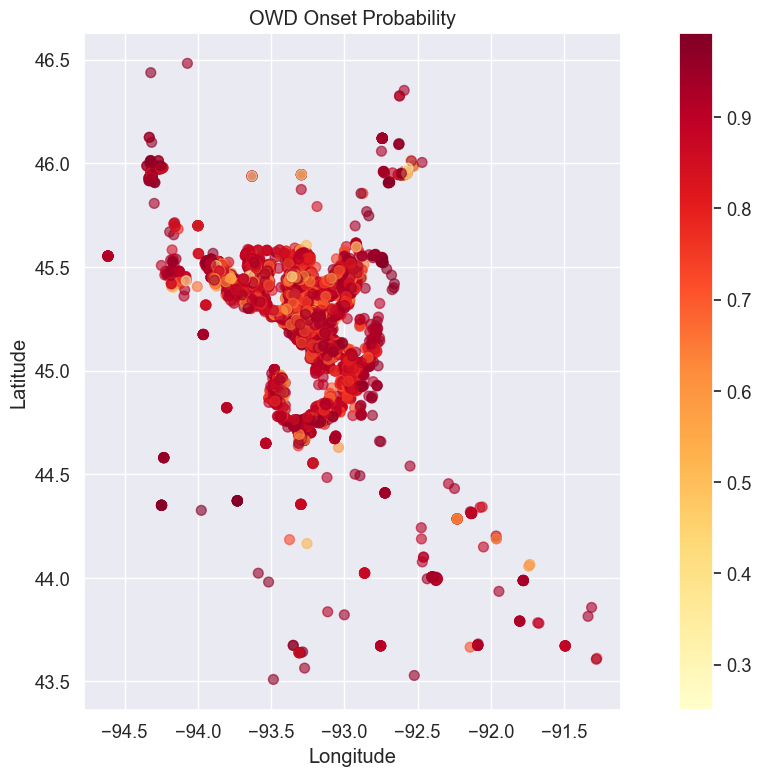

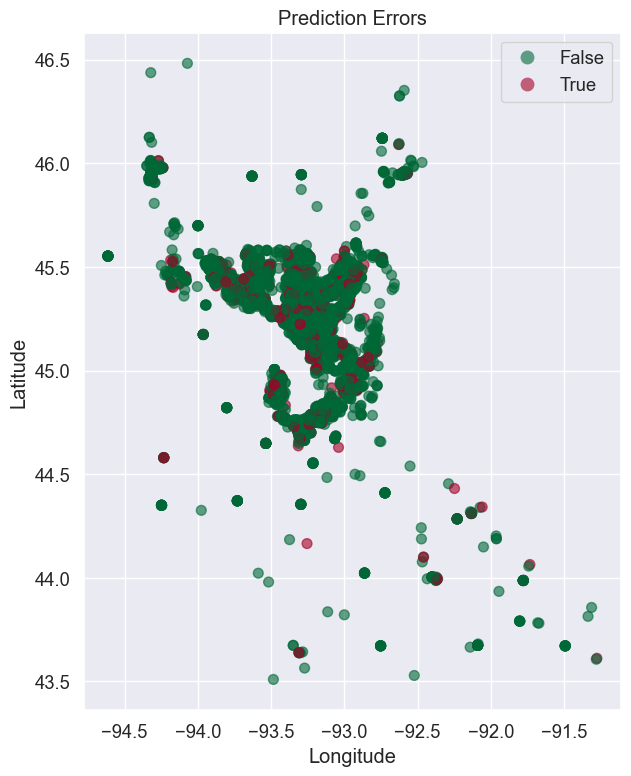

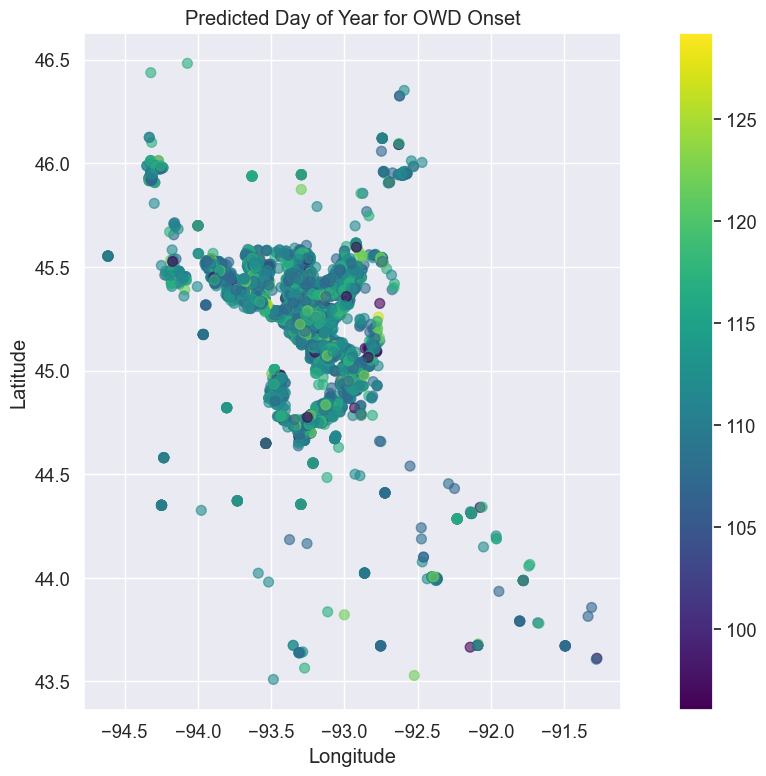


Prediction Summary:
Total points: 9880
Predicted onset: 9776 (98.9%)
Actual onset: 8659.0 (87.6%)
Overall accuracy: 0.878

Confusion Matrix:
True Positives: 8616
False Positives: 1160
True Negatives: 61
False Negatives: 43
Precision: 0.881
Recall: 0.995
F1-Score: 0.935


In [43]:
def create_prediction_maps(gdf, features_df, target_df, class_results, reg_results):
    """Create maps showing the predictions"""
    print("Creating prediction maps")
    
    # Get the best classification model (XGBoost or RandomForest if XGBoost isn't available)
    best_model_name = 'RandomForest' if 'XGBoost' not in class_results else 'XGBoost'
    best_model = class_results[best_model_name]['model']
    
    # Prepare data
    X = features_df[top_features].copy()
    X = X.fillna(X.mean())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Make predictions for all points
    onset_prob = best_model.predict_proba(X_scaled)[:, 1]
    onset_class = best_model.predict(X_scaled)
    
    # Create a copy of the GeoDataFrame with predictions
    prediction_gdf = gdf.copy()
    prediction_gdf['OWD_Onset_Probability'] = onset_prob
    prediction_gdf['OWD_Onset_Predicted'] = onset_class
    
    # For records predicted to have onset, predict the onset day
    if reg_results and best_model_name in reg_results:
        reg_model = reg_results[best_model_name]['model']
        
        # Initialize onset day predictions with NaN
        prediction_gdf['OWD_Onset_Day_Predicted'] = np.nan
        
        # Predict onset day for records with predicted onset
        onset_idx = prediction_gdf['OWD_Onset_Predicted'] == 1
        if np.any(onset_idx):
            X_onset = X_scaled[onset_idx]
            onset_days = reg_model.predict(X_onset)
            prediction_gdf.loc[onset_idx, 'OWD_Onset_Day_Predicted'] = onset_days
    
    # Add actual values for comparison
    prediction_gdf['OWD_Onset_Actual'] = target_df['OWD_Onset']
    prediction_gdf['OWD_Onset_Day_Actual'] = target_df['OWD_Onset_DOY']
    
    # Calculate prediction accuracy
    correct_predictions = (prediction_gdf['OWD_Onset_Predicted'] == prediction_gdf['OWD_Onset_Actual']).sum()
    accuracy = correct_predictions / len(prediction_gdf)
    print(f"Prediction accuracy: {accuracy:.3f}")
    
    # Create a map showing predicted vs. actual onset
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    
    # Map of predicted onset
    prediction_gdf.plot(ax=axs[0], column='OWD_Onset_Predicted', 
                      categorical=True, legend=True,
                      cmap='coolwarm', markersize=50, alpha=0.6)
    axs[0].set_title('Predicted OWD Onset')
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].grid(True)
    
    # Map of actual onset
    prediction_gdf.plot(ax=axs[1], column='OWD_Onset_Actual', 
                      categorical=True, legend=True,
                      cmap='coolwarm', markersize=50, alpha=0.6)
    axs[1].set_title('Actual OWD Onset')
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create a map showing prediction probability
    fig, ax = plt.subplots(figsize=(12, 8))
    prediction_gdf.plot(ax=ax, column='OWD_Onset_Probability', 
                      legend=True, cmap='YlOrRd', 
                      markersize=50, alpha=0.6)
    ax.set_title('OWD Onset Probability')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create a map showing prediction errors
    prediction_gdf['Prediction_Error'] = prediction_gdf['OWD_Onset_Predicted'] != prediction_gdf['OWD_Onset_Actual']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    prediction_gdf.plot(ax=ax, column='Prediction_Error', 
                      categorical=True, legend=True,
                      cmap='RdYlGn_r', markersize=50, alpha=0.6)
    ax.set_title('Prediction Errors')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # For points with predicted onset, create a map of predicted onset day
    if 'OWD_Onset_Day_Predicted' in prediction_gdf.columns:
        onset_gdf = prediction_gdf[prediction_gdf['OWD_Onset_Predicted'] == 1].copy()
        
        if len(onset_gdf) > 0:
            fig, ax = plt.subplots(figsize=(12, 8))
            onset_gdf.plot(ax=ax, column='OWD_Onset_Day_Predicted', 
                          legend=True, cmap='viridis', 
                          markersize=50, alpha=0.6)
            ax.set_title('Predicted Day of Year for OWD Onset')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.grid(True)
            plt.tight_layout()
            plt.show()
    
    return prediction_gdf

# Create prediction maps
prediction_gdf = create_prediction_maps(gdf, features_df, target_df, class_results, reg_results)

# Save the prediction GeoDataFrame to a shapefile (optional)
prediction_gdf.to_file('oak_wilt_predictions.shp')

# Calculate summary statistics
total_points = len(prediction_gdf)
predicted_onset = prediction_gdf['OWD_Onset_Predicted'].sum()
actual_onset = prediction_gdf['OWD_Onset_Actual'].sum()
correct_predictions = (prediction_gdf['OWD_Onset_Predicted'] == prediction_gdf['OWD_Onset_Actual']).sum()
accuracy = correct_predictions / total_points

# Display summary
print("\nPrediction Summary:")
print(f"Total points: {total_points}")
print(f"Predicted onset: {predicted_onset} ({predicted_onset/total_points*100:.1f}%)")
print(f"Actual onset: {actual_onset} ({actual_onset/total_points*100:.1f}%)")
print(f"Overall accuracy: {accuracy:.3f}")

# Calculate confusion matrix metrics
true_pos = ((prediction_gdf['OWD_Onset_Predicted'] == 1) & (prediction_gdf['OWD_Onset_Actual'] == 1)).sum()
false_pos = ((prediction_gdf['OWD_Onset_Predicted'] == 1) & (prediction_gdf['OWD_Onset_Actual'] == 0)).sum()
true_neg = ((prediction_gdf['OWD_Onset_Predicted'] == 0) & (prediction_gdf['OWD_Onset_Actual'] == 0)).sum()
false_neg = ((prediction_gdf['OWD_Onset_Predicted'] == 0) & (prediction_gdf['OWD_Onset_Actual'] == 1)).sum()

print("\nConfusion Matrix:")
print(f"True Positives: {true_pos}")
print(f"False Positives: {false_pos}")
print(f"True Negatives: {true_neg}")
print(f"False Negatives: {false_neg}")

# Calculate precision, recall, and F1-score
precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

In [44]:
# Create a copy to avoid modifying the original
export_gdf = prediction_gdf.copy()

# Rename columns to shorter versions
column_mapping = {
    'OWD_Onset_Probability': 'Prob',
    'OWD_Onset_Predicted': 'Pred',
    'OWD_Onset_Actual': 'Actual',
    'OWD_Onset_Day_Predicted': 'DayPred',
    'OWD_Onset_Day_Actual': 'DayAct',
    'Prediction_Error': 'Error'
}

# Apply renaming
export_gdf = export_gdf.rename(columns=column_mapping)

# Export with shorter column names
export_gdf.to_file('oak_wilt_predictions_minnesota.shp')